In [8]:
import bfrescox
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd


In [13]:
# To use a user-defined input, provide the appropriate path to the template you wish to usee

# name of template
template_file = "48Ca_Ozge.template"



# path to template directory
template_directory = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

# full path to template file
template_file_path = template_directory.joinpath(template_file)

# name of frescox input file to be generated
frescox_input = "48Ca_Ozge_user_defined.in"

# name of the frescox output file to be generated (the standard output name)
frescox_output = "48Ca_Ozge_user_defined.out"


In [ ]:
# for an user provided template the user must provide the filled out input file with parameter placeholder
# here the template looks like:

_ = '''
48Ca scattering
NAMELIST
 &FRESCO hcm=0.01 rmatch=40 rintp=0.20 hnl=@hnl@ rnl=@rnl@ centre=-0.25
	 jtmin=0.0  jtmax=35 absend=-1.0
	 thmin=0.00 thmax=180.00 thinc=1.0
	 iter=0 iblock=2 nnu=36
	 chans=1 treneg=1 xstabl=1
         elab(1)= 7.97 /

 &PARTITION namep='n'  massp=1.0 zp=0
            namet='48Ca'  masst= 48. zt=20  nex=1  /
 &STATES jp=0.5 bandp=1 ep=0.0 cpot=1 jt= 0 bandt= 1 et=0.0000 /
 &partition /

  &pot kp= 1 type= 0  p(1:3)= 1.000  48.  0.00 /
  &pot kp= 1 type= 1  p(1:6)= @V@    @r@    @a@     1.0  1.33  0.62 /
  &pot kp= 1 type= 2  p(1:6)= 0.0    0.0    0.0     @Ws@ @rs@  @as@ /
  &pot kp= 1 type= 3  p(1:6)= 6.6    1.33   0.62    0.0  1.36  0.63 /
  &pot /
 &overlap /
 &COUPLING /
'''

In [15]:
# you can now pass the parameter values to bfrescox as a dictionary, matching the placeholder names
user_defined_parameters =   {
                    "hnl":  0.1,
                    "rnl": 5.0,
                    "V":  49.284900,
                    "r":   0.907039,
                    "a":   0.679841,
                    "Ws":  3.394386,
                    "rs":  1.094115,
                    "as":  0.2763
                }

In [16]:
# Create the frescox input file by filling in the user-defined template with parameters
cfg = bfrescox.Configuration.from_template(
                    template_file_path,
                    frescox_input,
                    user_defined_parameters,
                    overwrite=True,
                )

In [17]:
# Run the frescox simulation
bfrescox.run_simulation(cfg, frescox_output, cwd=".", overwrite=True)

In [18]:
# Parse the frescox output file to extract differential cross section results
results_df = bfrescox.parse_differential_xs.absolute_mb_per_sr(
                            frescox_output
                        )

# Can also parse the results as ratio to Rutherford WHEN AVAILABLE
results_df_r2r = bfrescox.parse_differential_xs.ratio_to_rutherford(
                            frescox_output
                        )

In [20]:
print(results_df.head())
print(results_df_r2r.head()) # neutron scattering does not have ratio to Rutherford results

               differential_xs_absolute_mb_per_sr
angle_degrees                                    
0.01                                  2286.288392
1.00                                  2283.426954
2.00                                  2274.861393
3.00                                  2260.650634
4.00                                  2240.891761
Empty DataFrame
Columns: [differential_xs_ratio_to_rutherford]
Index: []


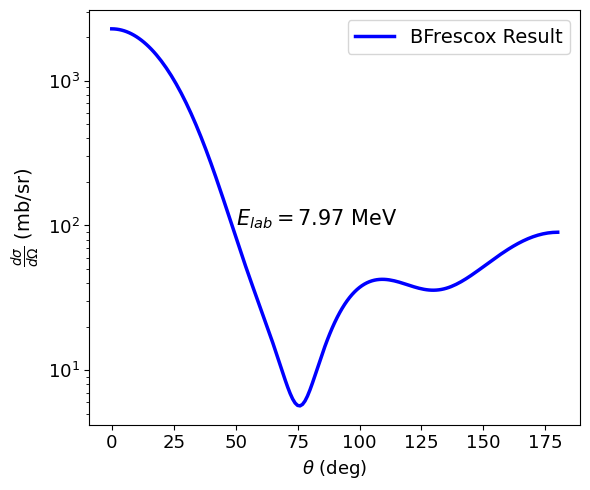

In [24]:
angles_deg = results_df.index.to_numpy()
diff_xs_mb_per_sr = results_df["differential_xs_absolute_mb_per_sr"].to_numpy()


# Create single figure and axis
fig, ax1 = plt.subplots(figsize=(6, 5))

# Global font size settings for ticks
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.tick_params(axis='both', which='minor', labelsize=11)

# Plot differential cross section
ax1.plot(angles_deg, diff_xs_mb_per_sr, lw=2.5, color='blue', label='BFrescox Result')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=14)
ax1.set_xlabel(r"$\theta$ (deg)", fontsize=13)

# Add annotation
ax1.text(50.0, 1e2, r"$E_{lab} = 7.97$ MeV",
         fontsize=15, color='black')

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

In [26]:
# you can always parse your own results from one of the fort files. For example for fort.16 one might use the 
# following function to parse the angular distributions

def parse_fort16(filename: Path):
    """
    Parse a FrescoX fort.16 output into a dict of DataFrames.
    Each '@sN ... &' block becomes one entry labeled channel_N,
    with all numeric columns and proper names (Theta, sigma, iT11, etc.).

    Parameters:
    filename : Path
        Path to the FrescoX fort.16 output file.

    Returns:
    dict of pd.DataFrame
        Dictionary with keys 'channel_1', 'channel_2', etc., each containing a
        DataFrame of the corresponding data.

    Raises:
    TypeError: If filename is not a string or Path.
    ValueError: If the file does not exist.
    """
    if (not isinstance(filename, str)) and (not isinstance(filename, Path)):
        raise TypeError(f"Invalid filename ({filename})")
    path = Path(filename).resolve()
    if not path.is_file():
        raise ValueError(f"{path} does not exist or is not a file")
    with open(path, "r") as f:
        content = f.read()
    raw_blocks = content.split("&")  # Split into blocks at "&"
    results = {}
    channel_idx = 1
    for block in raw_blocks:
        lines = block.splitlines()
        # Look for header line (columns after '#')
        header = None
        for line in lines:
            if line.strip().startswith("#") and "Theta" in line:
                # Remove "for projectile" etc. and split
                header = line.strip("# ").replace("for projectile", "").split()
                break
        # Collect numeric rows
        rows = []
        for line in lines:
            line = line.strip()
            if not line or line.startswith(("#", "@")):
                continue
            try:
                nums = [float(x) for x in line.split()]
                rows.append(nums)
            except ValueError:
                continue
        if rows:
            df = pd.DataFrame(rows)
            # Assign header if available and lengths match
            if header and len(header) >= df.shape[1]:
                df.columns = header[: df.shape[1]]
            else:
                df.columns = [f"col_{i + 1}" for i in range(df.shape[1])]
            results[f"channel_{channel_idx}"] = df.reset_index(drop=True)
            channel_idx += 1
    return results

In [27]:
results = parse_fort16(Path("fort.16"))
print(results["channel_1"].head())

   Theta   sigma
0   0.01  2286.0
1   1.00  2283.0
2   2.00  2275.0
3   3.00  2261.0
4   4.00  2241.0
